**Curso de Inteligencia Artificial y Aprendizaje Profundo**


# Modelo seq2seq. Construcción de un traductor

##  Autores

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Oleg Jarma, ojarmam@unal.edu.co
4. Maria del Pilar Montenegro, pmontenegro88@gmail.com

## Referencias

1. Basado en F. Collet, [Character-level recurrent sequence-to-sequence model](https://keras.io/examples/nlp/lstm_seq2seq/)
2. [Write a Sequence to Sequence (seq2seq) Model](https://docs.chainer.org/en/stable/examples/seq2seq.html)
3. Ilya Sutskever et al. (Google),[Sequence to Sequence Learning
with Neural Network](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf)

## Contenido

* [Importa módulos](#Importa-módulos)
* [Configuración](#Configuración)
* [Prepara los datos](#Prepara-los-datos)
* [Construye el modelo](#Construye-el-modelo)
* [Entrena el modelo](#Entrena-el-modelo)
* [Modelo de inferencia](#Modelo-de-inferencia)
* [Prueba del modelo](#Prueba-del-modelo)


## Introducción

El modelo de secuencia a secuencia (seq2seq)  es un modelo de aprendizaje que convierte una secuencia de entrada en una secuencia de salida. 

En este contexto, la secuencia es una lista de símbolos, correspondiente a las palabras en una oración. 

El modelo seq2seq ha logrado un gran éxito en campos como la traducción automática, los sistemas de diálogo, la respuesta a preguntas y el resumen de texto. 

Todas estas tareas pueden considerarse como la tarea de aprender un modelo que convierte una secuencia de entrada en una secuencia de salida.

La imagen muestra la arquitectura general del modelo.

<figure>
<center>
<img src="../Imagenes/seq2seq.png" width="500" height="300" align="center"/>
</center>
<figcaption>
<p style="text-align:center">Arquitectura del modelo seq2seq</p>
</figcaption>
</figure>

Fuente: [Write a Sequence to Sequence (seq2seq) Model](https://docs.chainer.org/en/stable/examples/seq2seq.html)

El modelo consta escencialmente de las soguientes capas.

1. Capa de incrustación de codificador
2. Capa recurrente del codificador
3. Capa de incrustación de decodificador
4. Capa recurrente del decodificador
5. Capa de salida del decodificador

Veámos la implementación en t.keras propuesta por F. Collet, [Character-level recurrent sequence-to-sequence model].

## Importa módulos


In [39]:
import numpy as np
import tensorflow as tf
#from tensorflow import keras

from tensorflow.keras.layers import Input, LSTM, Dense

from tensorflow.keras.models import Model

from tensorflow.keras.utils import plot_model

## Descarga los datos

Puede descargar los de [Tab-delimited Bilingual Sentence Pairs](http://www.manythings.org/anki/)

## Configuración


In [17]:
batch_size = 64 # tamño de los lotes para entrenamiento
epochs = 100 # Número de epochs
latent_dim = 256 # dimensión del espacio latente para el encoder
num_samples = 10000
# path del archivo
data_path = "../Datos/spa-eng/spa.txt" # 124548 lines

## Prepara los datos


In [18]:
# Vectoriza los datos
#
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n") # 124548 lines

for line in lines[:min(num_samples,len(lines)-1)]:
    input_text, target_text, _ = line.split("\t")
    # Usaremos "tab" como el  caracter de inicio (start sequence)
    # para los targets, y "\n" como el caracter de fin de secuencia "end sequence"
    target_text = "\t" + target_text + "\n"
    # sube las líneas a  las listas
    input_texts.append(input_text)
    target_texts.append(target_text)
    # completa los conjuntos de caracteres si es necesario
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

# Convierte los dos conjuntos de caracteres
# en dos listas ordenadas
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))  
# calcule el número de tokens (caracteres) en ambos lados
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
# calcula la máxima longitud de las secuencias en cada lado
max_encoder_seq_length = max([len(text) for text in input_texts])
max_decoder_seq_length = max([len(text) for text in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)
print("preparando datos...")
# crea diccionarios de tokens
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

# crea los tensores 1-hot para el encoder y el decoder
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")

decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")


for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

print ("....\ndatos preparados")    

Number of samples: 10000
Number of unique input tokens: 69
Number of unique output tokens: 84
Max sequence length for inputs: 16
Max sequence length for outputs: 42
preparando datos...
....
datos preparados


## Construye el modelo


### Encoder 

In [19]:
# define una secuencia de entrada y la procesa
encoder_inputs = Input(shape = (None, num_encoder_tokens))

# capa recurrente del encoder
encoder = LSTM(latent_dim, return_state = True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# Descartamos las salidas (encoder_outputs)
# solamente se conserva las memoria de  corto (state_h) y 
# largo plazo(state_c)
encoder_states = [state_h, state_c]
#

### Encoder 

In [19]:
# Configuramos el decoder, usando 'encoder_states' como estado inicial
decoder_inputs = Input(shape= (None, num_decoder_tokens))

# cpa recurrente del decoder
# Configuramos nuestro decodificador para devolver secuencias de salida completas,
# y también para devolver estados internos. No usamos los
# estados retornados en el modelo de entrenamiento, pero los usaremos en inferencia.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _,_ = decoder_lstm(decoder_inputs,initial_state = encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

### Modelo completo

In [19]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, 69)]   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None, 84)]   0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 256), (None, 333824      input_5[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, None, 256),  349184      input_6[0][0]                    
                                                                 lstm_4[0][1]               

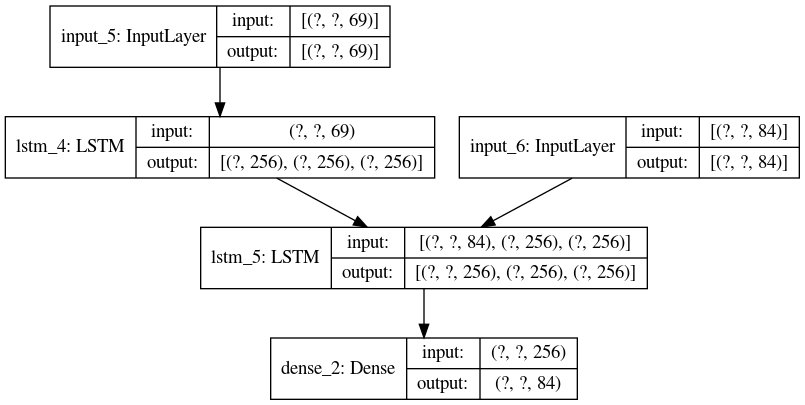

In [40]:
model.summary()
plot_model(model, to_file='../Imagenes/s2s.png', 
           show_shapes=True)

## Entrena el modelo

In [21]:
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 62s 8ms/sample - loss: 1.5442 - accuracy: 0.6512 - val_loss: 1.3454 - val_accuracy: 0.6225
Epoch 2/100
8000/8000 [==============================] - 61s 8ms/sample - loss: 1.0787 - accuracy: 0.7024 - val_loss: 1.1574 - val_accuracy: 0.6765
Epoch 3/100
8000/8000 [==============================] - 61s 8ms/sample - loss: 0.9135 - accuracy: 0.7419 - val_loss: 1.0237 - val_accuracy: 0.6992
Epoch 4/100
8000/8000 [==============================] - 53s 7ms/sample - loss: 0.8216 - accuracy: 0.7586 - val_loss: 0.9343 - val_accuracy: 0.7194
Epoch 5/100
8000/8000 [==============================] - 53s 7ms/sample - loss: 0.9171 - accuracy: 0.7470 - val_loss: 0.9705 - val_accuracy: 0.7142
Epoch 6/100
8000/8000 [==============================] - 54s 7ms/sample - loss: 0.7983 - accuracy: 0.7622 - val_loss: 0.9143 - val_accuracy: 0.7264
Epoch 7/100
8000/8000 [==============================] - 53s 7ms

In [29]:
# Save model
model.save("../Saved_Models/s2s")

INFO:tensorflow:Assets written to: ../Saved_Models/s2s/assets


## Modelo de inferencia

1. Codifica la entrada y recuperar el estado inicial del decodificador.
2. Ejecuta un paso del decodificador con este estado inicial y un token de "inicio de secuencia" como objetivo. La salida será el próximo token de destino.
3. Repite con el token de destino actual y los estados actuales

In [47]:
#
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

## Prueba del modelo

Ahora podemos generar oraciones decodificadas como tales:

In [50]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Oración de entrada:", input_texts[seq_index])
    print("Oración decodificada:", decoded_sentence)

-
Oración de entrada: Go.
Oración decodificada: Vaya.

-
Oración de entrada: Go.
Oración decodificada: Vaya.

-
Oración de entrada: Go.
Oración decodificada: Vaya.

-
Oración de entrada: Go.
Oración decodificada: Vaya.

-
Oración de entrada: Hi.
Oración decodificada: Hola.

-
Oración de entrada: Run!
Oración decodificada: ¡Corra!

-
Oración de entrada: Run!
Oración decodificada: ¡Corra!

-
Oración de entrada: Run!
Oración decodificada: ¡Corra!

-
Oración de entrada: Run!
Oración decodificada: ¡Corra!

-
Oración de entrada: Run.
Oración decodificada: Corred.

-
Oración de entrada: Who?
Oración decodificada: ¿Quién?

-
Oración de entrada: Wow!
Oración decodificada: ¡Órale!

-
Oración de entrada: Fire!
Oración decodificada: ¡Disparad!

-
Oración de entrada: Fire!
Oración decodificada: ¡Disparad!

-
Oración de entrada: Fire!
Oración decodificada: ¡Disparad!

-
Oración de entrada: Help!
Oración decodificada: ¡Auxilio!

-
Oración de entrada: Help!
Oración decodificada: ¡Auxilio!

-
Oración d